| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=64, thetas_dim=6, backcast_length=144, forecast_length=1, share_thetas=False) at @139122585794400
| --  Stack Generic (#1) (share_weights_in_stack=True)
     | -- GenericBlock(units=64, thetas_dim=6, backcast_length=144, forecast_length=1, share_thetas=False) at @139122585792480
Epoch 1, Train Loss: 0.4176, Val Loss: 1.7137
Epoch 2, Train Loss: 0.3219, Val Loss: 1.3751
Epoch 3, Train Loss: 0.2934, Val Loss: 1.3710
Epoch 4, Train Loss: 0.2737, Val Loss: 1.4690
Epoch 5, Train Loss: 0.2581, Val Loss: 1.4938
Epoch 6, Train Loss: 0.2485, Val Loss: 1.3342
Epoch 7, Train Loss: 0.2355, Val Loss: 1.3215
Epoch 8, Train Loss: 0.2317, Val Loss: 1.3634
Epoch 9, Train Loss: 0.2230, Val Loss: 1.2403
Epoch 10, Train Loss: 0.2142, Val Loss: 1.3066
Epoch 11, Train Loss: 0.2111, Val Loss: 1.3703
Epoch 12, Train Loss: 0.2018, Val Loss: 1.3113
Epoch 13, Train Loss: 0.2000, Val Loss: 1.3514
Epoch 14, Train Loss: 0.

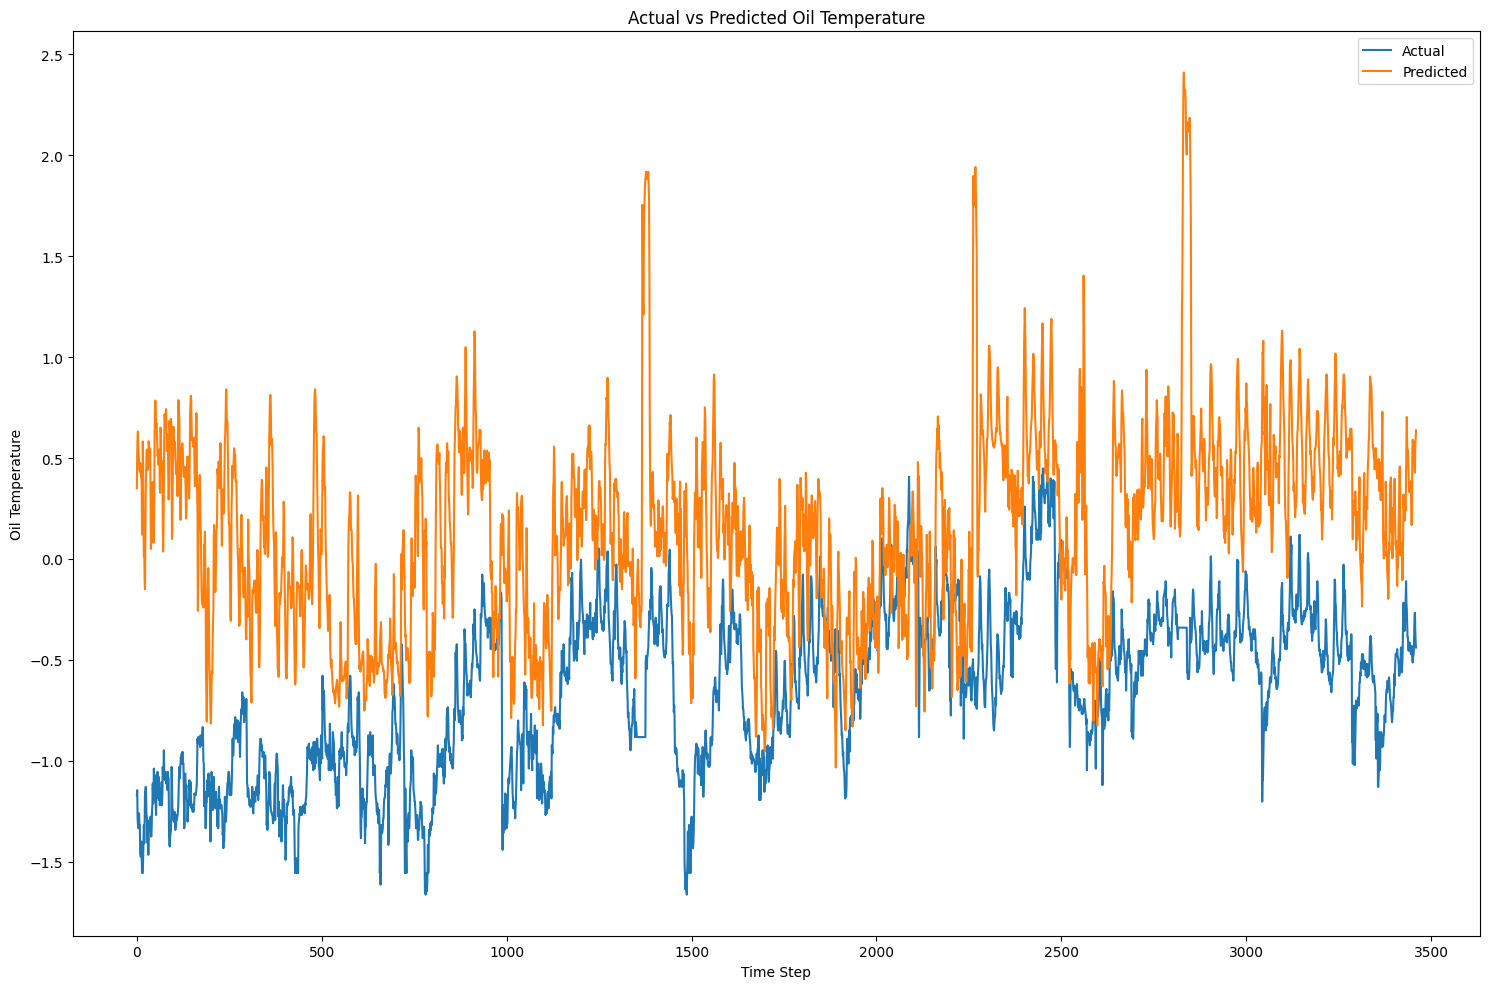

In [20]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from nbeats_pytorch.model import NBeatsNet
from sklearn.preprocessing import StandardScaler

# Load dataset
def load_data(filepath):
    data = pd.read_csv(filepath)
    return data

# Normalize the data
def normalize_data(data):
    scaler = StandardScaler()
    data[['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']] = scaler.fit_transform(data[['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']])
    return data, scaler

# Define a custom dataset
class ETTH1Dataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.sequence_length, :-1]
        y = self.data[idx + self.sequence_length, -1]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Preprocess the data
def preprocess_data(data):
    data['date'] = pd.to_datetime(data['date'])
    data.set_index('date', inplace=True)
    return data[['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']].values

# Split data into train, validation, and test sets
def split_data(processed_data):
    train_data, test_data = train_test_split(processed_data, test_size=0.2, shuffle=False)
    train_data, val_data = train_test_split(train_data, test_size=0.2, shuffle=False)
    return train_data, val_data, test_data

# Define the N-BEATS model
class NBeatsModel(torch.nn.Module):
    def __init__(self, input_dim, backcast_length, forecast_length=1):
        super(NBeatsModel, self).__init__()
        self.nbeats = NBeatsNet(
            backcast_length=backcast_length,
            forecast_length=forecast_length,
            stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
            nb_blocks_per_stack=1,
            thetas_dim=(input_dim, input_dim),
            share_weights_in_stack=True,
            hidden_layer_units=64
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input tensor
        _, forecast = self.nbeats(x)
        return forecast

# Train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100):
    best_val_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            x = x.view(x.size(0), -1)  # Flatten the input tensor
            y_pred = model(x)
            loss = criterion(y_pred, y.unsqueeze(-1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x = x.view(x.size(0), -1)  # Flatten the input tensor
                y_pred = model(x)
                loss = criterion(y_pred, y.unsqueeze(-1))
                val_loss += loss.item()
        val_loss /= len(val_loader)

        print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_nbeats_model.pth')

# Evaluate the model
def evaluate_model(model, loader, criterion):
    model.eval()
    loss = 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.view(x.size(0), -1)  # Flatten the input tensor
            pred = model(x)
            loss += criterion(pred, y.unsqueeze(-1)).item()
            y_true.append(y.numpy())
            y_pred.append(pred.numpy())
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    return loss / len(loader), y_true, y_pred

# Calculate R2 scores
def calculate_r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

# Plot actual vs predicted values for the test set
def plot_results(test_true, test_pred):
    plt.figure(figsize=(15, 10))
    plt.plot(test_true, label='Actual')
    plt.plot(test_pred, label='Predicted')
    plt.title('Actual vs Predicted Oil Temperature')
    plt.xlabel('Time Step')
    plt.ylabel('Oil Temperature')
    plt.legend()
    plt.tight_layout()
    plt.savefig('predictions_plot_NBEATS.png')
    plt.show()

def main():
    filepath = '/content/drive/MyDrive/ETTh1.csv'
    data = load_data(filepath)
    data, scaler = normalize_data(data)
    processed_data = preprocess_data(data)
    train_data, val_data, test_data = split_data(processed_data)

    sequence_length = 24
    input_dim = 6  # Number of input features
    backcast_length = sequence_length * input_dim
    train_dataset = ETTH1Dataset(train_data, sequence_length)
    val_dataset = ETTH1Dataset(val_data, sequence_length)
    test_dataset = ETTH1Dataset(test_data, sequence_length)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = NBeatsModel(input_dim, backcast_length)
    # criterion = torch.nn.MSELoss()
    criterion = torch.nn.L1Loss()  #MAE
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50)

    # Load the best model
    model.load_state_dict(torch.load('best_nbeats_model.pth'))

    train_loss, train_true, train_pred = evaluate_model(model, train_loader, criterion)
    val_loss, val_true, val_pred = evaluate_model(model, val_loader, criterion)
    test_loss, test_true, test_pred = evaluate_model(model, test_loader, criterion)

    print(f'Train MSE: {train_loss:.4f}, Val MSE: {val_loss:.4f}, Test MSE: {test_loss:.4f}')

    train_r2 = calculate_r2(train_true, train_pred)
    val_r2 = calculate_r2(val_true, val_pred)
    test_r2 = calculate_r2(test_true, test_pred)

    print(f'Train R2: {train_r2}')
    print(f'Val R2: {val_r2}')
    print(f'Test R2: {test_r2}')

    plot_results(test_true, test_pred)

if __name__ == "__main__":
    main()
